In [ ]:
!mkdir .kaggle


In [ ]:
import json
token = {"username": "triinutasa", "key": "0987fc18c8bc3b0d17e2b64581949d99"}
with open('/content/drive/MyDrive/kaggle.json', 'w') as file:
    json.dump(token, file)

# New Section

In [ ]:
!ls /content/.kaggle
!mkdir /root/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json


In [ ]:
!kaggle config set -n path -v /content
!chmod 600 ~/.kaggle/kaggle.json

- path is now set to: /content


In [ ]:
!cp /root/.kaggle/kaggle.json /content/.kaggle/kaggle.json

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.7.0


In [ ]:
GCS_PATH='/content/competitions/seizure-prediction'

ZIP_FILES = GCS_PATH + '/*.zip'
ZIP_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/*.zip'))
print('Zip Files:', len(ZIP_FILENAMES))



Zip Files: 0


Visualizing one sample:

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition


import matplotlib as mpl
from cycler import cycler
import scipy.io

In [ ]:
#Get all file names in the folder
def load_data(data_path, subject, test_data=False):
    read_dir = data_path + '/' + subject
    filenames = sorted(os.listdir(read_dir))
    train_filenames = []
    for filename in filenames:
        if test_data:
          if 'test' in filename:
            train_filenames.append(filename)
        else:
          if 'test' not in filename:
            train_filenames.append(filename)

    matfile = loadmat(read_dir + '/' + train_filenames[0], squeeze_me=True)
    key_list = matfile.keys()
    matching = [s for s in key_list if "segment" in s]
    segment_name = matching[0]
    data = matfile[segment_name].flat[0][0]
    print(data.shape)
    chnls = matfile[segment_name].flat[0][3]
    n = len(train_filenames)*len(chnls)
    x = np.zeros((n,data.shape[1]), dtype='float32')
    y = np.zeros(n, dtype='int8')
    channels = np.zeros(n, dtype='object')
    
    filename_to_idx = {}
    idx = 0
    for i, filename in enumerate(train_filenames):
        matfile = loadmat(read_dir + '/' + filename, squeeze_me=True)
        key_list = matfile.keys()
        matching = [s for s in key_list if "segment" in s]
        segment_name = matching[0]
        data = matfile[segment_name].flat[0][0]
        chnls = matfile[segment_name].flat[0][3]
        for j,chnl in enumerate(chnls):
          x[idx] = data[j]
          y[idx] = 1 if 'preictal' in filename else 0
          channels[idx] = chnl
          filename_to_idx[subject + '/' + filename] = i
          idx = idx + 1
        # x[i] = data
        # y[i] = 1 if 'preictal' in filename else 0
        # filename_to_idx[subject + '/' + filename] = i
        # channels[i] = chnls

    return {'x': x, 'y': y, 'filename_to_idx': filename_to_idx, 'channels': channels}

In [ ]:
def generate_pca_output(data_path, subject):
    read_dir = data_path + '/' + subject
    filenames = sorted(os.listdir(read_dir))
    for filename in filenames:
        matfile = loadmat(read_dir + '/' + filename, squeeze_me=True)
        key_list = matfile.keys()
        matching = [s for s in key_list if "segment" in s]
        segment_name = matching[0]
        data = matfile[segment_name].flat[0][0]
        chnls = matfile[segment_name].flat[0][3]

        df = pd.DataFrame(data.T, columns = chnls)

        x_std = StandardScaler().fit_transform(df)
        pca = decomposition.PCA(n_components=1)
        pca_res = pca.fit_transform(x_std)
        pca_res.tofile(read_dir + '/' + filename + '_pca.csv')


In [29]:
def load_pca_data(data_path, subject, test_data=False):
  read_dir = data_path + '/' + subject
  filenames = sorted(os.listdir(read_dir))
  train_filenames = []
  for filename in filenames:
    if test_data:
      if 'test' in filename:
        train_filenames.append(filename)
    else:
      if 'test' not in filename:
        train_filenames.append(filename)

  df = pd.read_csv(read_dir + '/' + train_filenames[0], header=None)
  print(df.shape)

  n = len(train_filenames)
  x = np.zeros((n,df.shape[0]), dtype='float32')
  y = np.zeros(n, dtype='int8')
  filename = np.zeros(n, dtype='object')
  print(df[0])
    
  idx = 0
  for i, fname in enumerate(train_filenames):
    df = pd.read_csv(read_dir + '/' + train_filenames[0], header=None)
    x[i] = df[0]
    y[i] = 1 if 'preictal' in fname else 0
    filename[i] = fname[:-8]

  return {'x': x, 'y': y, 'filename': filename}
  

In [30]:
def load_train_data(data_path, subject):
  return load_pca_data(data_path, subject)

def load_test_data(data_path, subject):
  return load_pca_data(data_path, subject, True)

In [19]:
import os
from scipy.io import loadmat
train_data = load_train_data("./drive/MyDrive/kaggle_data", "Patient_2")

(3000000, 1)
0          0.709062
1          0.740478
2          0.798615
3          0.809030
4          0.757367
             ...   
2999995    5.709414
2999996    5.741963
2999997    5.822004
2999998    5.905932
2999999    5.977189
Name: 0, Length: 3000000, dtype: float64


In [31]:
test_data = load_test_data("./drive/MyDrive/kaggle_data", "Patient_2")

(3000000, 1)
0         -2.013616
1         -2.014401
2         -2.014776
3         -2.014215
4         -2.011172
             ...   
2999995    0.065722
2999996    0.069535
2999997    0.074668
2999998    0.076525
2999999    0.074257
Name: 0, Length: 3000000, dtype: float64


In [20]:
train_data['x'].shape

(60, 3000000)

In [ ]:
train_data['y'].shape
df = pd.DataFrame(train_data['x'].T, columns = train_data['channels'])

df.head()

,LD_1,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,RD_1,RD_2,RD_3,RD_4,RD_5,RD_6,RD_7,RD_8,LD_1,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,RD_1,RD_2,RD_3,RD_4,RD_5,RD_6,RD_7,RD_8,LD_1,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,RD_1,RD_2,RD_3,...,LD_7,LD_8,RD_1,RD_2,RD_3,RD_4,RD_5,RD_6,RD_7,RD_8,LD_1,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,RD_1,RD_2,RD_3,RD_4,RD_5,RD_6,RD_7,RD_8,LD_1,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,RD_1,RD_2,RD_3,RD_4,RD_5,RD_6,RD_7,RD_8
0,122.0,641.0,358.0,351.0,299.0,99.0,227.0,533.0,935.0,581.0,1335.0,653.0,379.0,1425.0,589.0,-220.0,-297.0,-253.0,218.0,-545.0,16.0,145.0,-300.0,-1065.0,-48.0,-16.0,-838.0,-578.0,-1074.0,-651.0,68.0,135.0,-183.0,2489.0,1317.0,1762.0,1232.0,265.0,-62.0,189.0,...,-22841.0,-23011.0,-23314.0,-23242.0,-23130.0,-23296.0,-23270.0,-23156.0,-23457.0,-23383.0,-21341.0,-21321.0,-21589.0,-21755.0,-21949.0,-22019.0,-21728.0,-21170.0,-21569.0,-21681.0,-21177.0,-21505.0,-21590.0,-22156.0,-21283.0,13638.0,13163.0,13632.0,13230.0,13406.0,13441.0,13501.0,12605.0,12849.0,12723.0,12503.0,12358.0,11201.0,12460.0,12699.0
1,122.0,642.0,358.0,351.0,300.0,98.0,226.0,533.0,935.0,581.0,1335.0,653.0,380.0,1423.0,590.0,-219.0,-297.0,-253.0,218.0,-546.0,17.0,146.0,-300.0,-1065.0,-49.0,-15.0,-838.0,-578.0,-1074.0,-653.0,68.0,134.0,-184.0,2490.0,1317.0,1762.0,1233.0,265.0,-63.0,188.0,...,-26301.0,-26471.0,-26780.0,-26705.0,-26597.0,-26764.0,-26735.0,-26616.0,-26919.0,-26846.0,-18060.0,-18037.0,-18301.0,-18470.0,-18666.0,-18737.0,-18445.0,-17881.0,-18281.0,-18391.0,-17886.0,-18218.0,-18308.0,-18872.0,-17993.0,17166.0,16695.0,17163.0,16756.0,16933.0,16969.0,17031.0,16137.0,16382.0,16258.0,16038.0,15893.0,14728.0,15988.0,16234.0
2,122.0,642.0,356.0,350.0,300.0,98.0,225.0,534.0,935.0,582.0,1337.0,653.0,379.0,1422.0,591.0,-218.0,-297.0,-253.0,218.0,-545.0,19.0,146.0,-300.0,-1065.0,-49.0,-14.0,-838.0,-578.0,-1073.0,-655.0,68.0,133.0,-183.0,2491.0,1317.0,1762.0,1236.0,265.0,-62.0,188.0,...,-31526.0,-31696.0,-32010.0,-31939.0,-31832.0,-32001.0,-31972.0,-31841.0,-32150.0,-32093.0,-13354.0,-13328.0,-13590.0,-13767.0,-13962.0,-14033.0,-13735.0,-13169.0,-13570.0,-13680.0,-13169.0,-13506.0,-13602.0,-14166.0,-13276.0,21981.0,21518.0,21977.0,21567.0,21743.0,21787.0,21852.0,20964.0,21206.0,21075.0,20859.0,20713.0,19545.0,20800.0,21037.0
3,122.0,643.0,356.0,349.0,300.0,99.0,225.0,535.0,935.0,584.0,1339.0,654.0,379.0,1422.0,592.0,-217.0,-297.0,-252.0,218.0,-543.0,19.0,145.0,-298.0,-1064.0,-49.0,-14.0,-838.0,-579.0,-1073.0,-655.0,68.0,133.0,-183.0,2491.0,1317.0,1763.0,1237.0,264.0,-62.0,187.0,...,-34575.0,-34745.0,-35059.0,-34992.0,-34883.0,-35054.0,-35030.0,-34887.0,-35201.0,-35154.0,-10335.0,-10307.0,-10571.0,-10755.0,-10947.0,-11015.0,-10713.0,-10150.0,-10550.0,-10662.0,-10146.0,-10483.0,-10586.0,-11150.0,-10253.0,24413.0,23952.0,24409.0,23997.0,24172.0,24222.0,24287.0,23404.0,23644.0,23505.0,23291.0,23147.0,21977.0,23230.0,23456.0
4,124.0,644.0,357.0,350.0,300.0,101.0,228.0,536.0,937.0,586.0,1341.0,655.0,379.0,1422.0,592.0,-216.0,-298.0,-252.0,219.0,-542.0,19.0,143.0,-297.0,-1064.0,-48.0,-14.0,-838.0,-580.0,-1072.0,-654.0,67.0,133.0,-183.0,2489.0,1316.0,1763.0,1237.0,262.0,-63.0,184.0,...,-36934.0,-37106.0,-37420.0,-37355.0,-37241.0,-37416.0,-37398.0,-37246.0,-37559.0,-37508.0,-7342.0,-7312.0,-7576.0,-7768.0,-7958.0,-8023.0,-7717.0,-7157.0,-7555.0,-7669.0,-7152.0,-7485.0,-7599.0,-8161.0,-7259.0,25674.0,25210.0,25674.0,25256.0,25433.0,25483.0,25547.0,24667.0,24909.0,24765.0,24551.0,24409.0,23237.0,24492.0,24715.0


In [ ]:
x_std = StandardScaler().fit_transform(df)
pca = decomposition.PCA(n_components=1)
pca_res = pca.fit_transform(x_std)

KeyboardInterrupt: ignored

In [ ]:
pca_res.shape

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_data['x'],train_data['y'])



RandomForestClassifier()

In [8]:
y_pred=clf.predict(test_data['x'])

NameError: ignored

In [9]:
train_data['filename_to_idx']

{'Patient_2/Patient_2_interictal_segment_0001.mat_pca.csv': 0}

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5 MB 5.1 MB/s 


In [ ]:
from pyts.datasets import load_gunpoint
from pyts.classification import TimeSeriesForest
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)


In [ ]:
from pyts.classification import TimeSeriesForest
clf = TimeSeriesForest(n_estimators=100, random_state=43)
clf.fit(train_data['x'],train_data['y'])


In [33]:
clf_res = clf.predict(test_data['x'])
clf_res

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [37]:
results = pd.DataFrame(list(zip(test_data['filename'], clf_res)), columns =['clip', 'preictal'])
results

,clip,preictal
0,Patient_2_test_segment_0001.mat,0
1,Patient_2_test_segment_0002.mat,0
2,Patient_2_test_segment_0003.mat,0
3,Patient_2_test_segment_0004.mat,0
4,Patient_2_test_segment_0005.mat,0
5,Patient_2_test_segment_0006.mat,0
6,Patient_2_test_segment_0007.mat,0
7,Patient_2_test_segment_0008.mat,0
8,Patient_2_test_segment_0009.mat,0
9,Patient_2_test_segment_0010.mat,0


In [ ]:
interictal_data_1 = scipy.io.loadmat('Patient_1_preictal_segment_0001.mat')          # loads the file as a dictionary
interictal_data_2 = scipy.io.loadmat('Patient_1_preictal_segment_0002.mat')          # loads the file as a dictionary
interictal_data_3 = scipy.io.loadmat('Patient_1_preictal_segment_0003.mat')          # loads the file as a dictionary
interictal_data_4 = scipy.io.loadmat('Patient_1_preictal_segment_0004.mat')          # loads the file as a dictionary
interictal_data_5 = scipy.io.loadmat('Patient_1_preictal_segment_0005.mat')          # loads the file as a dictionary
interictal_data_6 = scipy.io.loadmat('Patient_1_preictal_segment_0006.mat')          # loads the file as a dictionary
# print(sorted(interictal_data.keys()))
# data_len_sec = interictal_data['interictal_segment_1']['data_length_sec']
# data_len_sec[0][0][0][0]

Display EEG data for this specific file:

In [ ]:
data_1 = interictal_data_1['preictal_segment_1'][0][0][0]
data_2 = interictal_data_2['preictal_segment_2'][0][0][0]
data_3 = interictal_data_3['preictal_segment_3'][0][0][0]
data_4 = interictal_data_4['preictal_segment_4'][0][0][0]
data_5 = interictal_data_5['preictal_segment_5'][0][0][0]
data_6 = interictal_data_6['preictal_segment_6'][0][0][0]

data = np.concatenate((data_1,data_2),axis=1)
data = np.concatenate((data,data_3),axis=1)
data = np.concatenate((data,data_4),axis=1)
data = np.concatenate((data,data_5),axis=1)
data = np.concatenate((data,data_6),axis=1)
print(data.shape)
# data = data_seg[0][0][0]
nr_electrodes = data.shape[0]
nr_samples = data.shape[1]
electrode_names = interictal_data_1['preictal_segment_1'][0][0][3][0]
print(nr_electrodes)
t = 60 * np.arange(nr_samples) / nr_samples


(15, 18000000)
15


In [ ]:
# Plot the EEG
fig = plt.figure("EEG samples",figsize=(30,15))

ticklocs = []
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(0, 60)
ax.set_xticks(np.arange(60))
dmin = data.min()
dmax = data.max()
dr = (dmax - dmin) * 0.7   #crowd it a bit
y0 = dmin
y1 = (nr_electrodes -1) * dr + dmax
ax.set_ylim(y0, y1)

segs = []
for electrode in range(nr_electrodes):
    segs.append(np.column_stack((t, data[electrode, :])))
    ticklocs.append(electrode * dr)
    
offsets = np.zeros((nr_electrodes, 2), dtype=float)
offsets[:, 1] = ticklocs

lines = LineCollection(segs, offsets=offsets, transOffset=None)
ax.add_collection(lines)

# Set the yticks to use axes coordinates on the y axis
ax.set_yticks(ticklocs)
ax.set_yticklabels(electrode_names)

ax.set_xlabel('Time (minutes)')
from google.colab import files
plt.savefig("eeg_plot.png")
files.download("eeg_plot.png") 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install mne

     |████████████████████████████████| 7.4 MB 6.4 MB/s 


In [ ]:
import mne
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

['LD_1', 'LD_3', 'LD_4', 'LD_5', 'LD_6', 'LD_7', 'LD_8', 'RD_1', 'RD_2', 'RD_3', 'RD_4', 'RD_5', 'RD_6', 'RD_7', 'RD_8']
5000.0
Creating RawArray with float64 data, n_channels=15, n_times=3000000
    Range : 0 ... 2999999 =      0.000 ...   600.000 secs
Ready.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


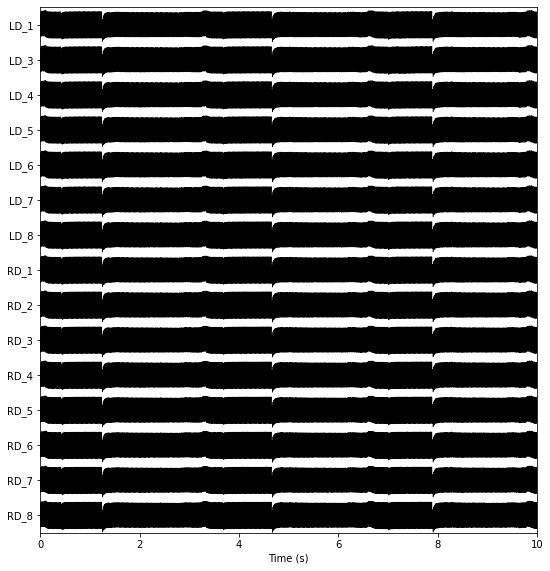

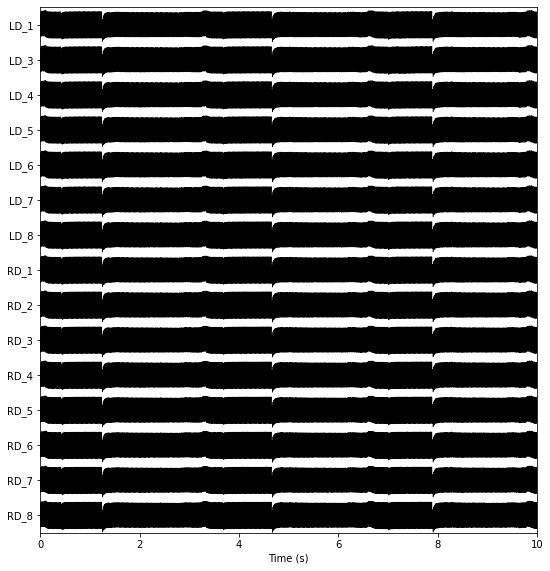

In [ ]:
#Convert .mat data into MNE raw data
data = interictal_data_1['preictal_segment_1'][0][0][0]
n_channels = data.shape[0]
nr_samples = data.shape[1]
nr_electrodes = data.shape[0]
nr_samples = data.shape[1]
electrode_names_arr = interictal_data_1['preictal_segment_1'][0][0][3][0]
electrode_names = []
for x in electrode_names_arr:
  electrode_names.append(list(x)[0])

sampling_freq = nr_samples / 600 # in Hertz
print(electrode_names)
print(sampling_freq)
info = mne.create_info(ch_names=electrode_names, ch_types=['eeg'] * nr_electrodes,
                       sfreq=sampling_freq)

raw_data = mne.io.RawArray(interictal_data_1['preictal_segment_1'][0][0][0], info)
# simulated_raw.plot(show_scrollbars=False, show_scalebars=False)

Effective window size : 0.410 (s)


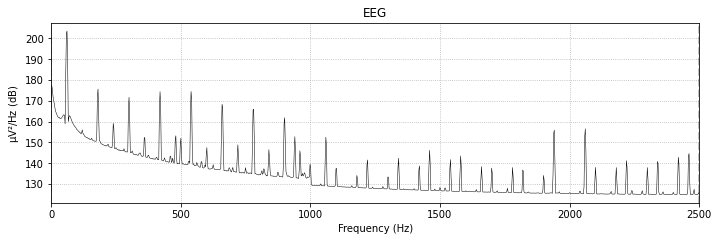

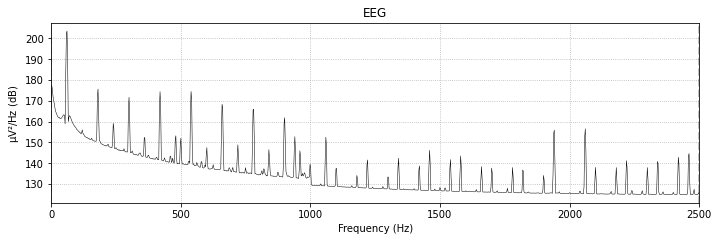

In [ ]:
# raw_data.plot()
# raw_data.pick_channels(['LD_1'])
raw_data.plot_psd(average=True)

In [ ]:
X = raw_data.get_data()
wsize = 5000
res = mne.time_frequency.stft(X, wsize, tstep=None, verbose=None)


Number of frequencies: 2501
Number of time steps: 1200


In [ ]:
print(res.shape)

(15, 2501, 1200)


In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame
import numpy as np
from datetime import timedelta


ModuleNotFoundError: ignored

In [ ]:
dataframe = DataFrame()
data = {'Time':[1,2,3,4,5,6],
        'Amount':[1683, 1321, 1447, 0, 86, 1165]}
 
# Create DataFrame
df = pd.DataFrame(data)

In [ ]:
dataframe = DataFrame()
for i in range(1, 0, -1):
   dataframe['t-' + str(i)] = df.Amount.shift(i)
dataframe


,t-1
0,NaN
1,1683.0
2,1321.0
3,1447.0
4,0.0
5,86.0


In [ ]:
final_data = pd.concat([df, dataframe], axis=1)



,Time,Amount,t-1
0,1,1683,NaN
1,2,1321,1683.0
2,3,1447,1321.0
3,4,0,1447.0
4,5,86,0.0
5,6,1165,86.0


In [ ]:
final_data.dropna(inplace=True)

In [ ]:
final_data

,Time,Amount,t-1
1,2,1321,1683.0
2,3,1447,1321.0
3,4,0,1447.0
4,5,86,0.0
5,6,1165,86.0


In [ ]:
finaldf = final_data.drop(['Time'], axis=1)
finaldf = finaldf.reset_index(drop=True)
test_length=2
end_point = len(finaldf)
x = end_point - test_length


In [ ]:
finaldf_train = finaldf.loc[:x - 1, :]
finaldf_test = finaldf.loc[x:, :]
finaldf_test_x = finaldf_test.loc[:, finaldf_test.columns != 'SaleQty']
finaldf_test_y = finaldf_test['SaleQty']
finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'SaleQty']
finaldf_train_y = finaldf_train['SaleQty']
print("Starting model train..")
rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), 4)
fit = rfe.fit(finaldf_train_x, finaldf_train_y)
y_pred = fit.predict(finaldf_test_x)